# Homework#4 Image Segmentation
#### การบ้านลำดับที่ 4 ในวิชา 01205481 Digital Image Processing มีวัตถุประสงค์ให้นิสิตได้ศึกษาทดลองการทำ Image Segmentation เพื่อให้เกิดความเข้าใจกระบวนการ โดยให้นิสิตทำการบ้านตามขั้นตอนที่กำหนดให้ซึ่งมีรายละเอียดดังต่อไปนี้

In [1]:
# All
import cv2
import matplotlib.pyplot as plt
import numpy as np

# 2
import seaborn as sebrn
import pandas as pd
from sklearn.metrics import confusion_matrix

## 1. การเตรียมภาพสำหรับการทดลอง Segmentation
#### ให้ทำการเตรียมและแสดงภาพที่จำเป็นต่อการทำ Segmentation และการวัดผลหลังจากการทำ Segmentation ดังนี้
    • ภาพนำเข้าต้นฉบับ 1 ภาพ
    • ภาพ binary image ที่แสดงถึงบริเวณที่ต้องการ (ground truth)

In [2]:
def readImagefromFile(filename):
    img = cv2.imread(str(filename))
    print(f"Shape in put image is {img.shape}")
    img_out = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print(f"Shape out put image RGB is {img_out.shape}")
    return img_out
def ImageSubplot(img_in,img_name,Title):
    fig, axs = plt.subplots(2, len(img_in), figsize=(30, 12))
    fig.suptitle(Title, fontsize=30)
    for i in range(len(img_in)):
        axs[0,i].imshow(img_in[i], cmap="gray")
        axs[0,i].set_xlabel(img_name[i], fontsize=15)
        axs[1,i].hist(img_in[i].flatten(),bins=256)
        axs[1,i].set_xlabel('Hist image '+ str(img_name[i]), fontsize=15)
    plt.show()

In [3]:
IMG_Origi = readImagefromFile("P3.3 Stew Detection and Fish Density Classification#3/40 (2).JPG")

Shape in put image is (3078, 5472, 3)
Shape out put image RGB is (3078, 5472, 3)


In [4]:
IMG_Grund_truth = readImagefromFile("P3.3 Stew Detection and Fish Density Classification#3_ground_truth/40 (2).JPG")
IMG_Grund_truth = cv2.cvtColor(IMG_Grund_truth, cv2.COLOR_RGB2GRAY)
print(f"Shape out put image GRAY is {IMG_Grund_truth.shape}")

Shape in put image is (3078, 5472, 3)
Shape out put image RGB is (3078, 5472, 3)
Shape out put image GRAY is (3078, 5472)


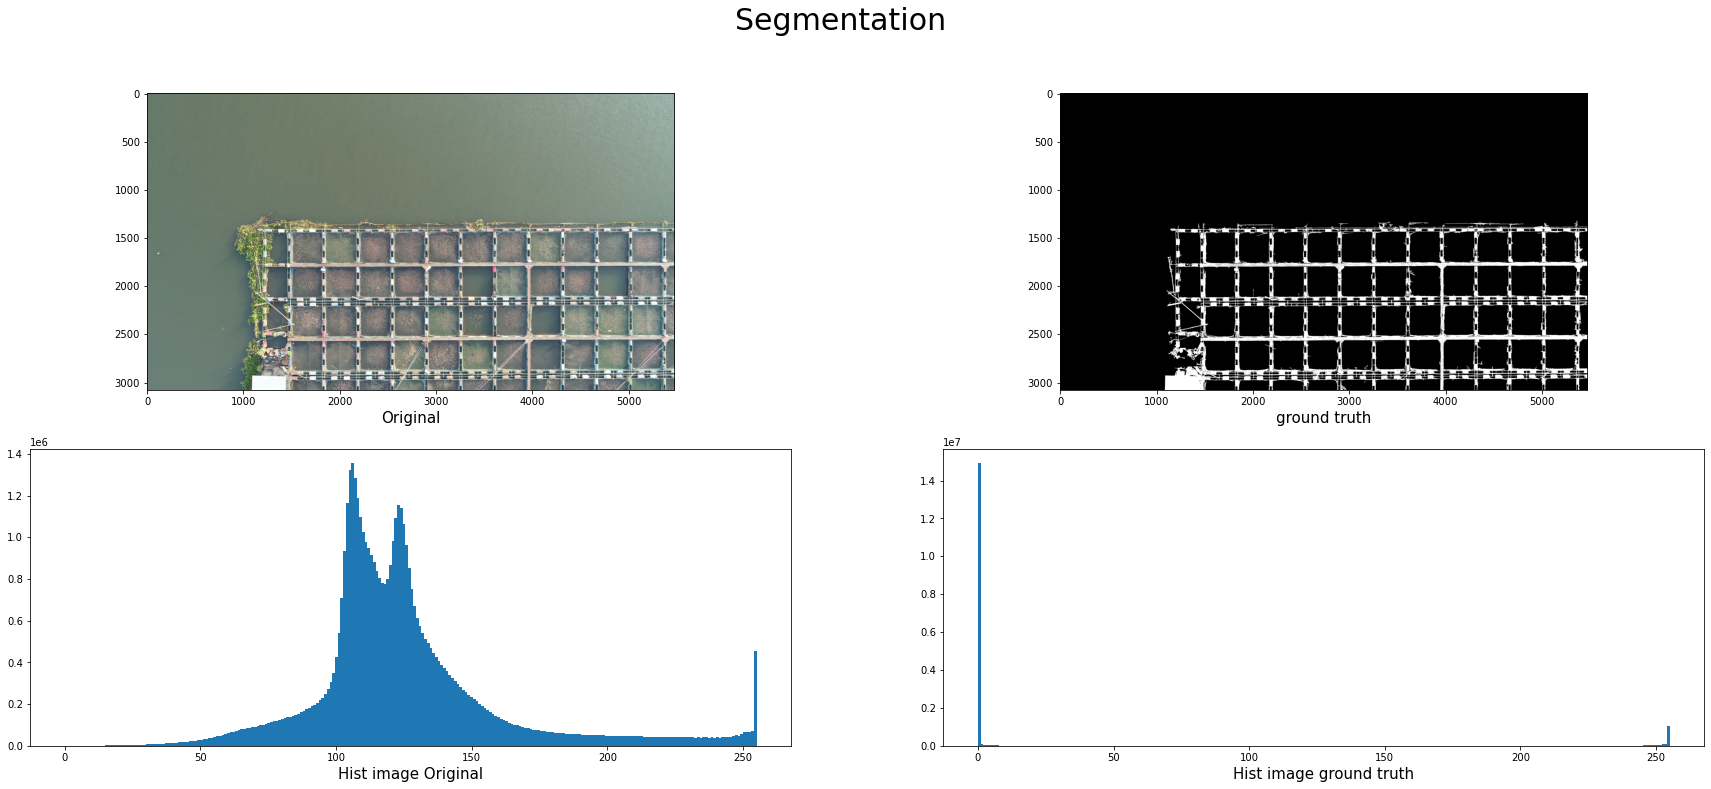

In [5]:
ImageSubplot(img_in = [IMG_Origi,IMG_Grund_truth],img_name =["Original","ground truth"],Title = "Segmentation")

In [6]:
# Grund truth to Binary
_, IMG_Grund_truth_binary = cv2.threshold(IMG_Grund_truth, 200, 1,cv2.THRESH_BINARY)

## 2. การทดลอง Segmentation โดยวิธี Thresholding
#### นำภาพนำเข้าต้นฉบับแปลงเป็น Grayscale หรือเลือก Channel สีหนึ่งสีจากภาพสี (เช่น ภาพสี RGB อาจเลือก Channel สี R มาใช้ เป็นต้น) จากนั้นทำการทดลองดังต่อไปนี้

In [7]:
def findIoU(gt_img, output_img):
    # Intersection (AND operation)
    intersect = np.logical_and(gt_img, output_img)
    # Union (OR operation)
    union = np.logical_or(gt_img, output_img)
    ### Intersection over Union (IoU)
    IoU = np.sum(intersect) / np.sum(union)
    return IoU

def findAccuracy(gt_img, output_img):
    # - Total number of pixels
    IMG_HEIGHT, IMG_WIDTH = gt_img.shape
    total_pixel = IMG_HEIGHT * IMG_WIDTH
    # - Compare pixel (XOR and then Invert)
    comp_pixel = ~np.logical_xor(gt_img, output_img)
    match_pixel = np.sum(comp_pixel)
    ### -> Accuracy
    accuracy = match_pixel / total_pixel
    return accuracy

def segmentConfusionMatrix(gt_img, output_img):
    # (true,predict
    matrix = confusion_matrix(gt_img.flatten(),output_img.flatten()).T
    con_matrix = np.zeros((matrix.shape[0]+1,matrix.shape[1]+1))
    con_matrix[:2, :2] = matrix
    # Precision
    prec_bg = matrix[0, 0] / np.sum(matrix[0, :])
    prec_fg = matrix[1, 1] / np.sum(matrix[1, :])
    con_matrix[:2,-1] = [prec_bg, prec_fg]
    # Recall
    rec_bg = matrix[0, 0] / np.sum(matrix[:, 0])
    rec_fg = matrix[1, 1] / np.sum(matrix[:, 1])
    con_matrix[-1,:2] = [rec_bg, rec_fg]
    # Accuracy
    accuracy = (matrix[0, 0] + matrix[1, 1]) / np.sum(matrix)
    con_matrix[-1, -1] = accuracy
    return con_matrix

def plotConfusionMatrix(conf_matrix):
    # Using Seaborn heatmap to create the plot
    ax = sebrn.heatmap(conf_matrix, annot=True, cmap='turbo')

    # labels the title and x, y axis of plot
    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('Predictions ')
    ax.set_ylabel('Actuals ');

    # labels the boxes
    ax.xaxis.set_ticklabels(['False','True',"Accuracy"])
    ax.yaxis.set_ticklabels(['False','True',"Recall"])
    plt.show()

    
def IoU_Conf_Plotconf(gt_img, output_img):
    IoU = findIoU(gt_img, output_img)
    print(f"Intersection over Union {IoU:.2f}")
    conf_matrix = segmentConfusionMatrix(gt_img, output_img)
    df = pd.DataFrame(conf_matrix, columns = ['False = 0','True = 1',"Precision"], index = ['False = 0','True = 1',"Recall"])
    # displaying the DataFrame
    display(df)
    plotConfusionMatrix(conf_matrix)
    

In [8]:
# -> Get Red-channel image
red_img = IMG_Origi[:,:,0]

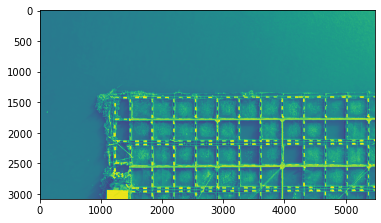

In [9]:
plt.imshow(red_img)

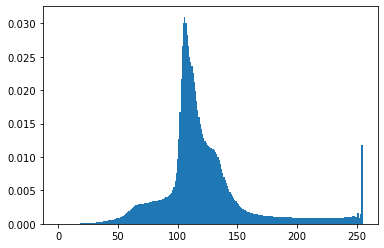

In [10]:
plt.hist(red_img.flatten(), bins=256, density=True)
plt.show()

### 2.1 หาจุด Optimum Threshold จาก Histogram และทำการ Thresholding โดยใช้จุด Optimum Threshold ข้างต้น ระบุจุด Optimum Threshold บน Histogram ที่เลือกใช้และแสดงภาพก่อนและหลังการประมวลผล พร้อมวัดผลโดยคำนวณหา IoU และ Confusion Matrix และแสดงหรือแนบโปรแกรม Python ที่ใช้


#### เมื่อพิขารณากราฟ Histogram เลือก Optimum Threshold ที่ 200 

In [11]:
_, output_img_Optimum_Threshold = cv2.threshold(red_img, 200, 1,cv2.THRESH_BINARY)

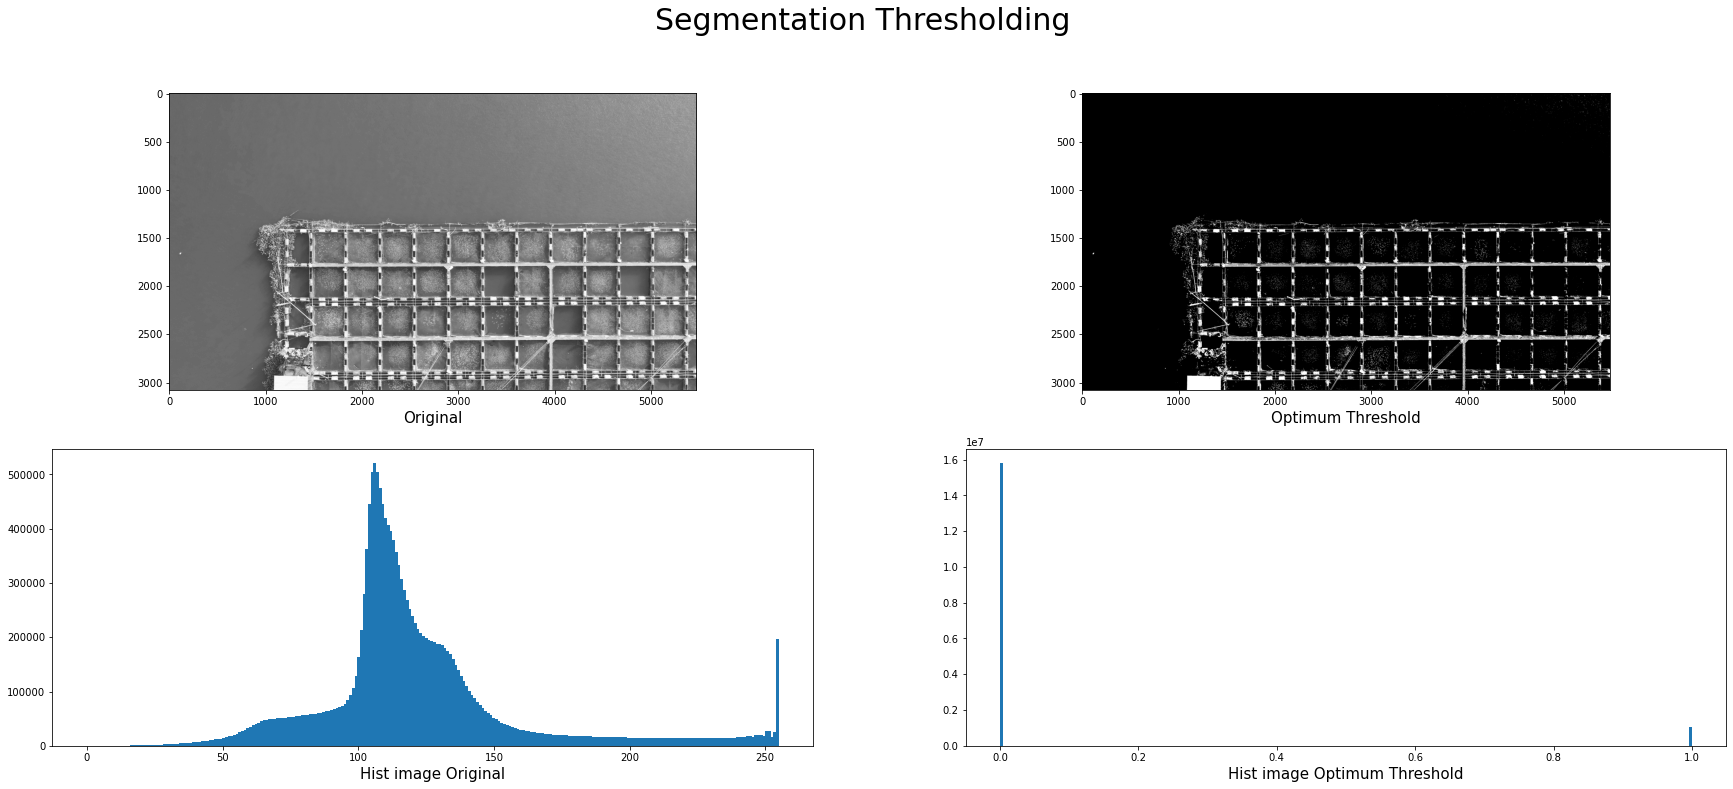

In [12]:
ImageSubplot(img_in = [red_img,output_img_Optimum_Threshold],img_name =["Original","Optimum Threshold"],Title = "Segmentation Thresholding")

Intersection over Union 0.56


False = 0       True = 1  Precision
False = 0  1.515602e+07  632309.000000   0.959951
True = 1   1.147650e+05  939721.000000   0.891165
Recall     9.924847e-01       0.597775   0.955644

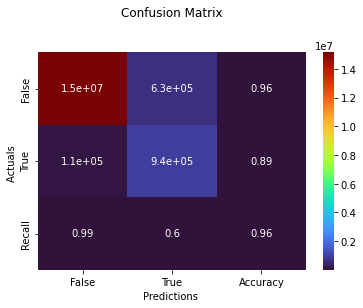

In [13]:
IoU_Conf_Plotconf(IMG_Grund_truth_binary, output_img_Optimum_Threshold)

In [16]:
output_img_Optimum_Threshold.shape

(3078, 5472)

In [17]:
segmentConfusionMatrix(IMG_Grund_truth_binary, output_img_Optimum_Threshold)

array([[1.51560210e+07, 6.32309000e+05, 9.59950862e-01],
       [1.14765000e+05, 9.39721000e+05, 8.91164985e-01],
       [9.92484670e-01, 5.97775488e-01, 9.55644353e-01]])

### 2.2 ทำการทดลอง Segmentation โดยใช้วิธี Otsu Thresholding ระบุจุด Threshold ที่วิธี Otsu Thresholding ใช้และแสดงภาพก่อนและหลังการประมวลผล พร้อมวัดผลโดยคำนวณหา IoU และ Confusion Matrix และแสดงหรือแนบโปรแกรม Python ที่ใช้

In [14]:
t_otsu, output_img_Otsu_Thresholding = cv2.threshold(red_img, None, 1,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print(f"Otsu Thresholding {t_otsu}")

Otsu Thresholding 161.0


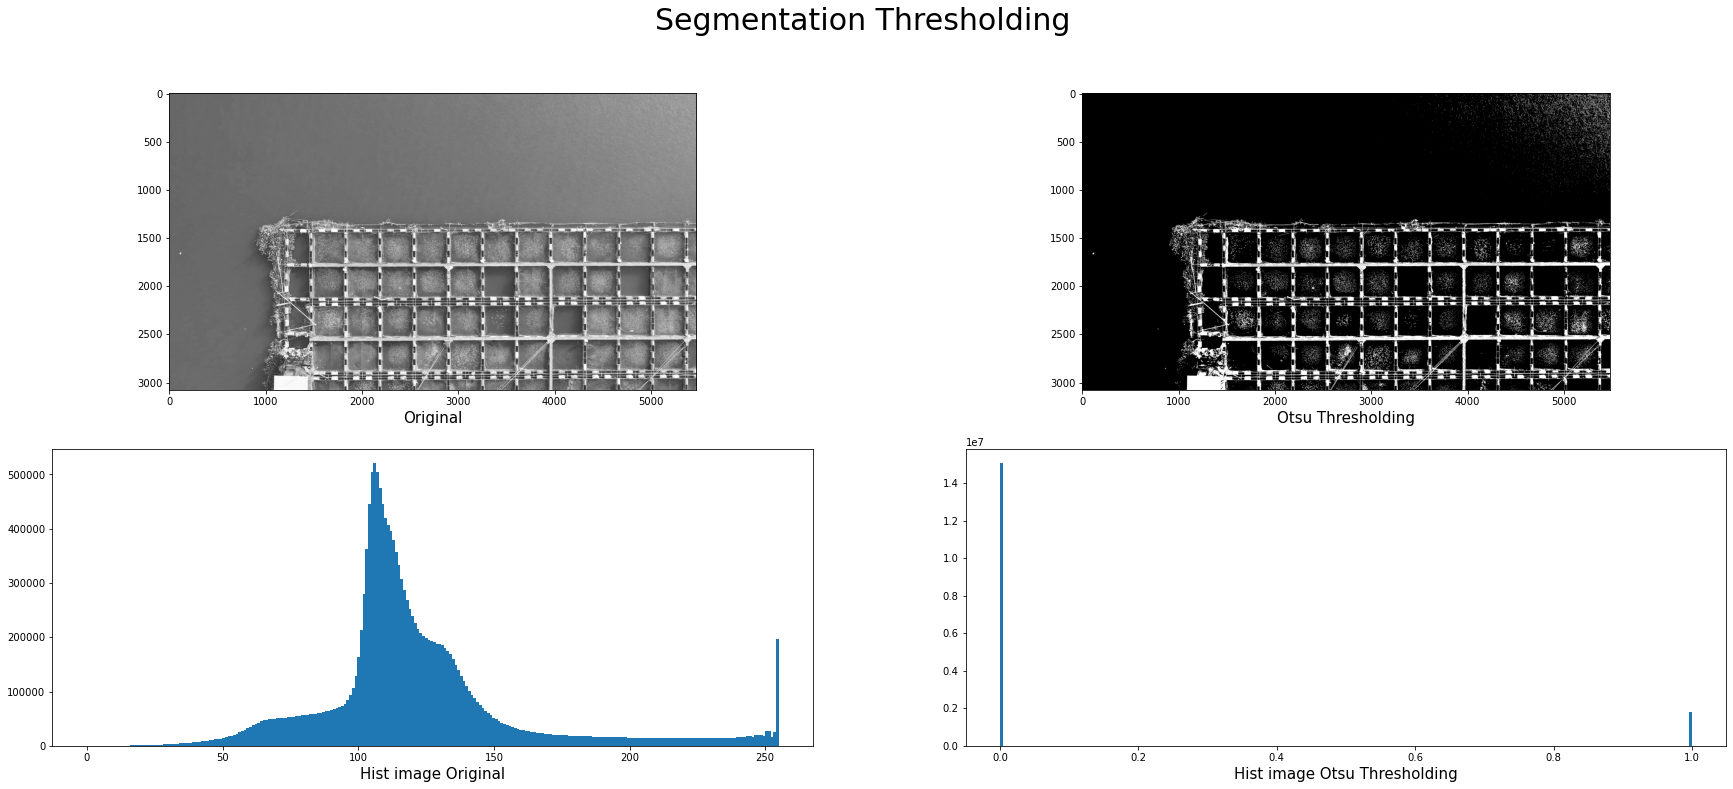

In [15]:
ImageSubplot(img_in = [red_img,output_img_Otsu_Thresholding],img_name =["Original","Otsu Thresholding"],Title = "Segmentation Thresholding")

Intersection over Union 0.63


False = 0      True = 1  Precision
False = 0  1.477893e+07  2.621190e+05   0.982573
True = 1   4.918580e+05  1.309911e+06   0.727014
Recall     9.677909e-01  8.332608e-01   0.955235

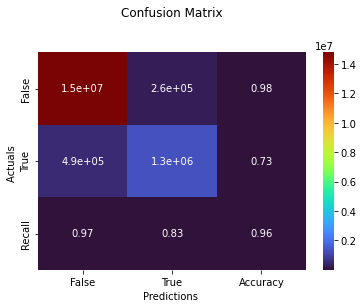

In [16]:
IoU_Conf_Plotconf(IMG_Grund_truth_binary, output_img_Otsu_Thresholding)

## 3. การทดลอง Color Image Segmentation
#### นำภาพนำเข้าต้นฉบับ และภาพ ground truth ที่เตรียมในข้อ 1 มาใช้ในการทดลองดังต่อไปนี้

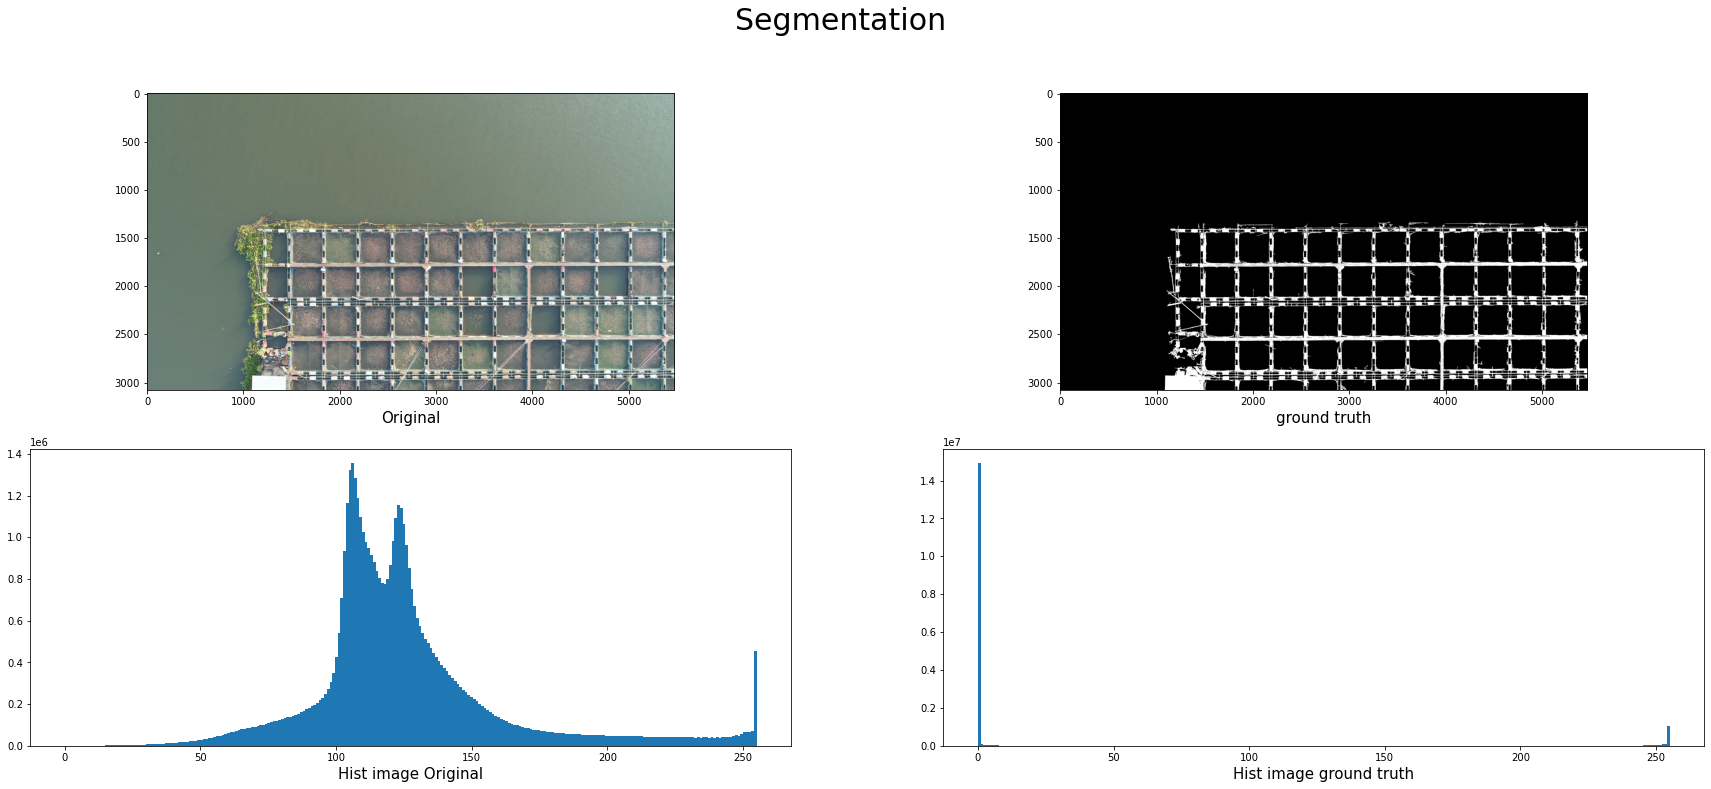

In [17]:
ImageSubplot(img_in = [IMG_Origi,IMG_Grund_truth],img_name =["Original","ground truth"],Title = "Segmentation")

In [18]:
# -> Get Red-channel image
red_img = IMG_Origi[:,:,0]
# -> Get Green-channel image
green_img = IMG_Origi[:,:,1]
# -> Get Blue-channel image
blue_img = IMG_Origi[:,:,2]

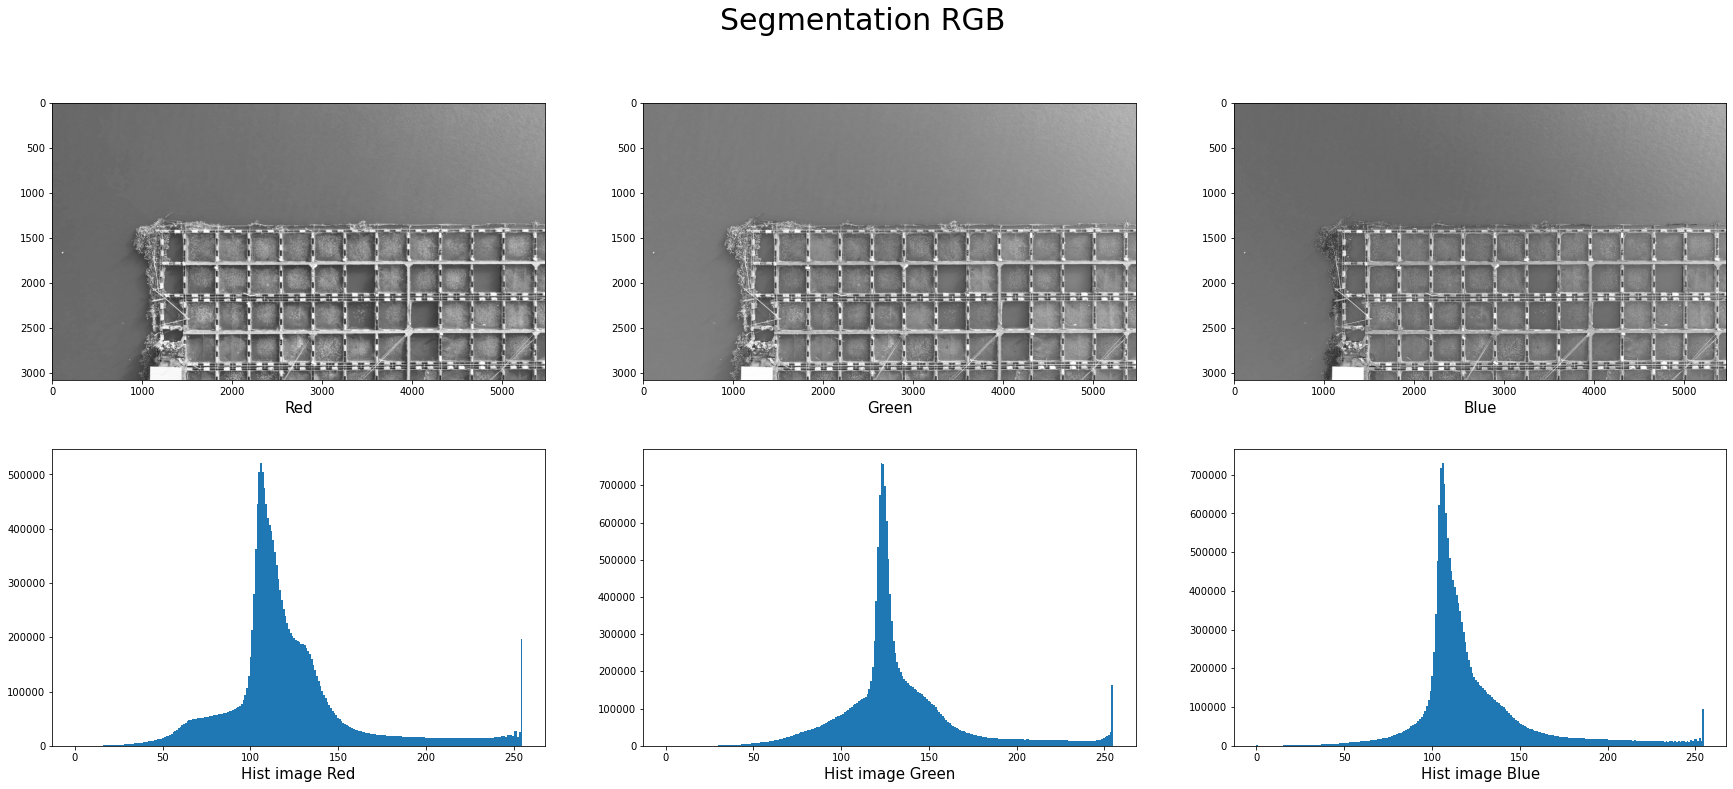

In [19]:
ImageSubplot(img_in = [red_img,green_img,blue_img],img_name =["Red","Green","Blue"],Title = "Segmentation RGB")

### 3.1 ทดลองเลือกช่วงสีที่ต้องการ (ขึ้นอยู่กับ color model ที่ใช้) โดยใช้คำสั่ง “cv2.inRange(…)” (แนะนำใน Program-16) โดยกำหนดช่วงสีตามวัตถุประสงค์ที่ต้องการจากภาพนำเข้า แสดงภาพก่อนและหลังการประมวลผล พร้อมวัดผลโดยการหา IoU และ Confusion Matrix และแสดงหรือแนบโปรแกรม Python ที่ใช้


#### เมื่อพิจารณา Histograms ของทั้ง 3 สี RGB ซึ่งได้เลือก Range ที่อยู่ในช่วงที่มีการ peak ของค่าสี

In [20]:
lower_bound = (200, 220, 220)
upper_bound = (255, 255, 255)
### -> Color Range Segmentation
output_img_inRange = cv2.inRange(IMG_Origi,lower_bound, upper_bound)
cv2.imwrite("Segmentation.JPG",output_img_inRange)

True

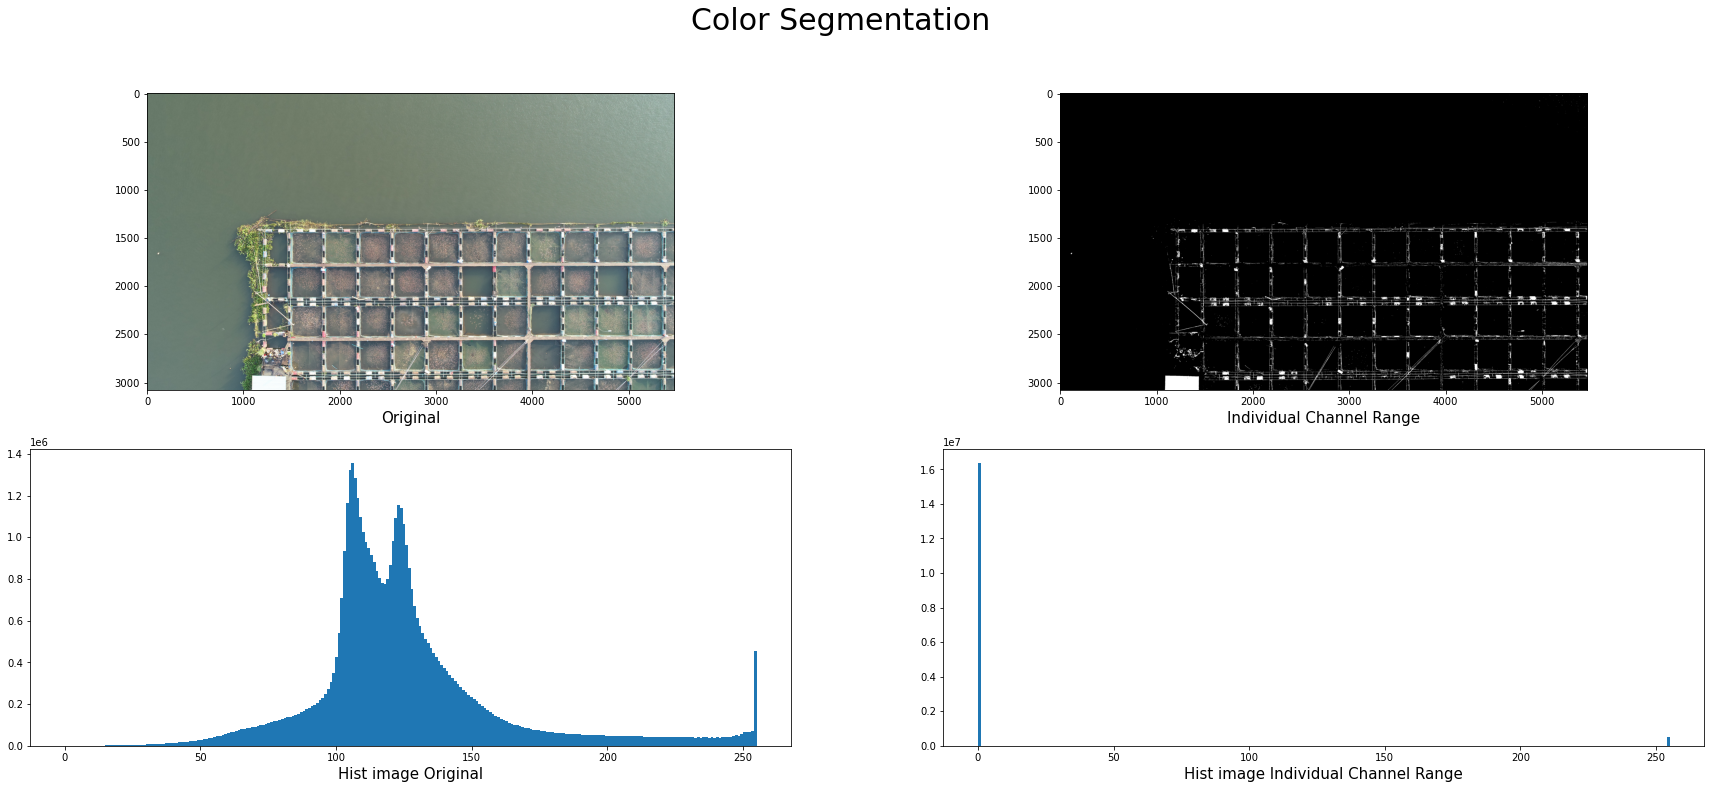

In [21]:
ImageSubplot(img_in = [IMG_Origi,output_img_inRange],img_name =["Original","Individual Channel Range"],Title = "Color Segmentation")

In [22]:
# convert 0 - 255 to 0 - 1 
_, output_img_inRange = cv2.threshold(output_img_inRange, 200, 1,cv2.THRESH_BINARY)

Intersection over Union 0.30


False = 0      True = 1  Precision
False = 0  1.525684e+07  1.089090e+06   0.933372
True = 1   1.394300e+04  4.829400e+05   0.971939
Recall     9.990869e-01  3.072079e-01   0.934510

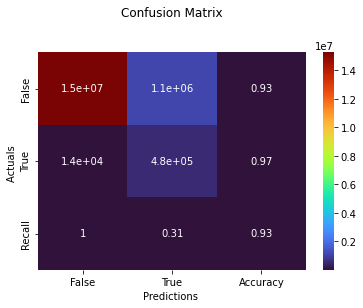

In [23]:
IoU_Conf_Plotconf(IMG_Grund_truth_binary, output_img_inRange)

### 3.2 ทดลองทำ Color Segmentation โดยใช้วิธีการเลือกสีรอบๆ บริเวณสีที่เลือกเป็นจุดศูนย์กลาง โดยใช้วิธีการคำนวณการกระจัดประเภท Euclidean และกำหนดค่า cut off เพื่อทำ Color Segmentation แสดงภาพก่อนและหลังการประมวลผล พร้อมวัดผลโดยคำนวณหา IoU และ Confusion Matrix พร้อมแสดงหรือแนบโปรแกรม Python ที่ใช้


In [24]:
def EuclideanDistance(IMG_IN,center_pos,Radius_cutoff):
    
    y, x, c = IMG_IN.shape
    IMG_IN_reshape = IMG_IN.reshape(y*x, c)
    
    # D(i) = sqrt((Fr(i) - Center_R)**2 + (Fg(i) - Center_G)**2 + (Fb(i) - Center_B)**2)
    
    center_color = center_pos*np.ones((y*x, 1))
    Diff = IMG_IN_reshape - center_color
    print(f"Diff shape {Diff.shape}")
    # print(Diff)
    
    Squares_diff = np.square(Diff)
    print(f"Squares Diff shape {Squares_diff.shape}")
    # print(Squares_diff)
    
    Sum_Squares_diff = np.sum(Squares_diff, axis=1)
    print(f"Sum Squares Diff shape {Sum_Squares_diff.shape}")
    # print(Sum_Squares_diff)
    
    Eucli_Dis = np.sqrt(Sum_Squares_diff)
    print(f"Euclidean Distance shape {Eucli_Dis.shape}")
    print(Eucli_Dis)
    
    plt.hist(Eucli_Dis.flatten(), bins=256, density=True)
    plt.xlabel('Euclidean Distance', fontsize=15)
    plt.show()
    
    Gi = np.zeros((y*x))
    Gi[Eucli_Dis>Radius_cutoff] = 1
    print(f"After Cut off shape {Gi.shape}")
    
    Out_IMG = Gi.reshape(y,x)
    print(f"Out put Image shape {Out_IMG.shape}")
 
    
    return Out_IMG

Diff shape (16842816, 3)
Squares Diff shape (16842816, 3)
Sum Squares Diff shape (16842816,)
Euclidean Distance shape (16842816,)
[183.72261701 185.44271353 187.16303054 ... 169.22765731 162.32683081
 157.15279189]


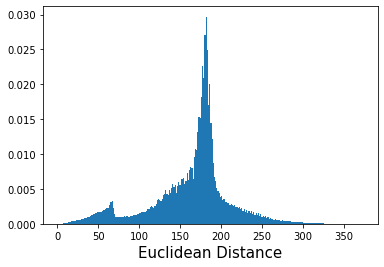

After Cut off shape (16842816,)
Out put Image shape (3078, 5472)


In [33]:
IMG_OUT_EuclideanDistance = EuclideanDistance(IMG_Origi,center_pos = (200,220,230),Radius_cutoff =250)
#IMG_OUT_EuclideanDistance = np.where(IMG_OUT_EuclideanDistance == 0,0,255)
#cv2.imwrite("Segmentation.JPG",IMG_OUT_EuclideanDistance)

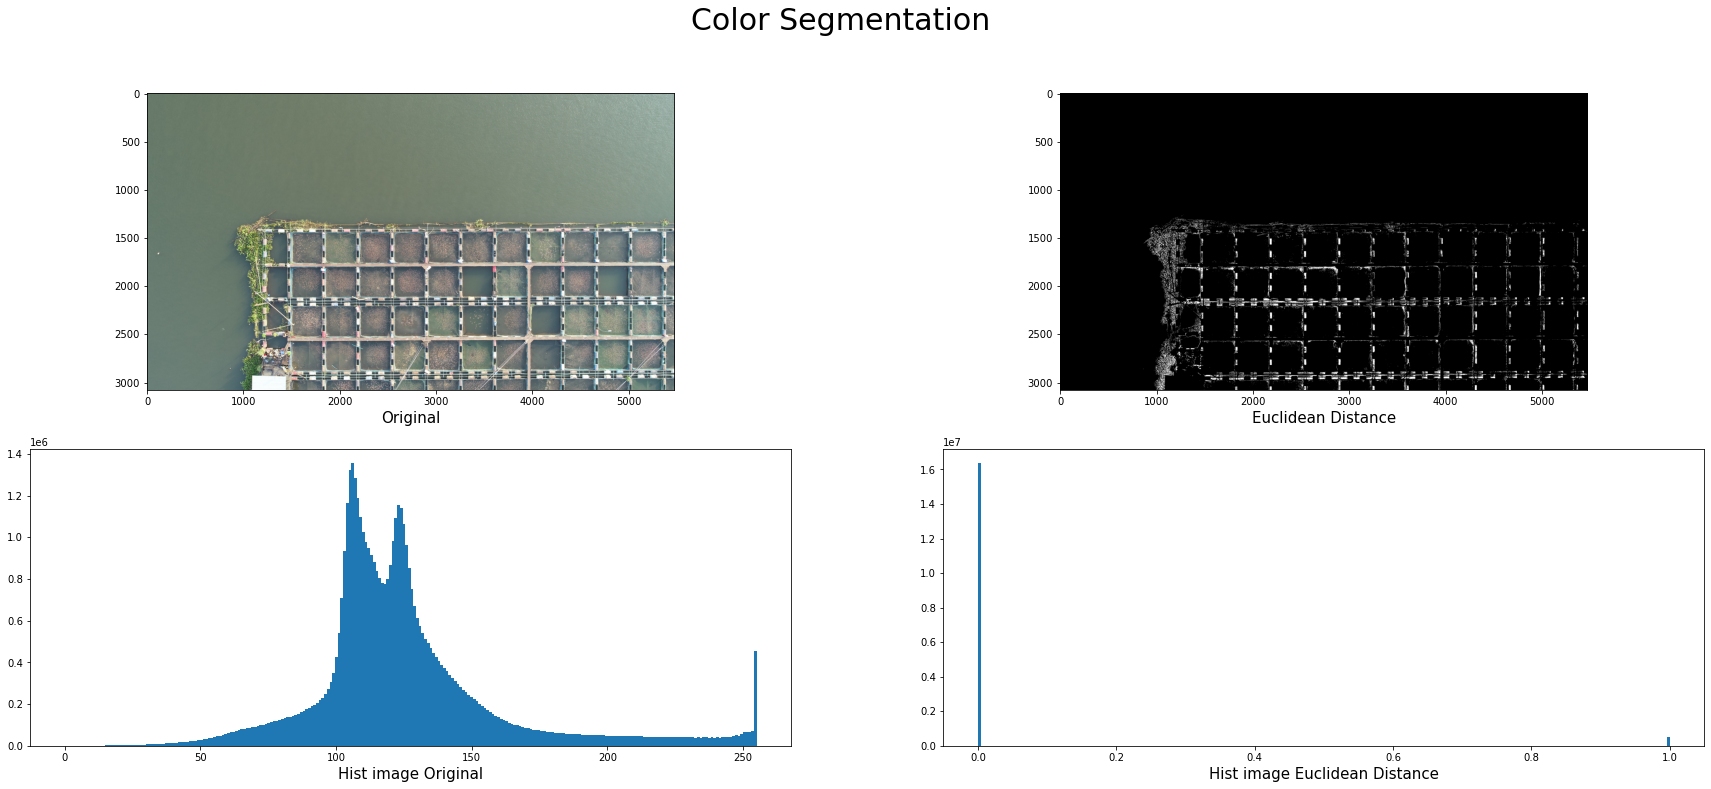

In [34]:
ImageSubplot(img_in = [IMG_Origi,IMG_OUT_EuclideanDistance],img_name =["Original","Euclidean Distance"],Title = "Color Segmentation")

Intersection over Union 0.00


False = 0   True = 1  Precision
False = 0  1.477655e+07  1572030.0   0.903843
True = 1   4.942330e+05        0.0   0.000000
Recall     9.676354e-01        0.0   0.877321

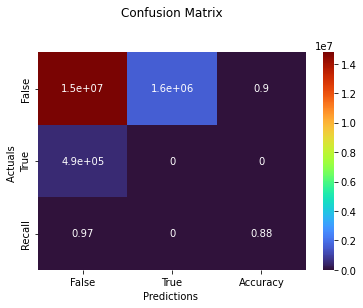

In [35]:
IoU_Conf_Plotconf(IMG_Grund_truth_binary, IMG_OUT_EuclideanDistance)

### 3.3 ทดลองทำ Color Segmentation โดยใช้วิธีการเลือกสีรอบๆ บริเวณสีที่เลือกเป็นจุดศูนย์กลาง โดยใช้วิธีการคำนวณการกระจัดประเภท Mahalanobis และกำหนดค่า cut off เพื่อทำ Color Segmentation แสดงภาพก่อนและหลังการประมวลผล พร้อมวัดผลโดยคำนวณหา IoU และ Confusion Matrix พร้อมแสดงหรือแนบโปรแกรม Python ที่ใช้

In [36]:
def mahalanobisDistance(input_IMG, center_pos, Radius_cutoff):
    y, x, c = input_IMG.shape
    input_rec = input_IMG.reshape(y*x, c)
    
    center_pos = center_pos*np.ones((y*x, 1))
    
    ### -> Find Invert Covariance
    cov = np.cov(input_rec.T)
    inv_cov = np.linalg.inv(cov)
    ### -> Find Mahalanobis Distance
    delta = input_rec - center_pos
    distances = np.sqrt(np.einsum("ij,jk,ik->i", delta, inv_cov, delta))
    
    plt.hist(distances.flatten(), bins=256, density=True)
    plt.xlabel('Mahalanobis Distance', fontsize=15)
    plt.show()
    
    Gi = np.zeros((y*x))
    Gi[distances>Radius_cutoff] = 1
    print(f"After Cut off shape {Gi.shape}")
    
    Out_IMG = Gi.reshape(y,x)
    print(f"Out put Image shape {Out_IMG.shape}")
    
    
    return Out_IMG

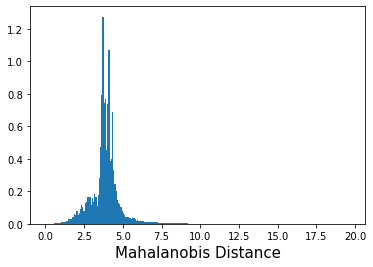

After Cut off shape (16842816,)
Out put Image shape (3078, 5472)


In [37]:
IMG_OUT_mahalanobisDistance = mahalanobisDistance(IMG_Origi, center_pos = (150,120,110), Radius_cutoff = 5)

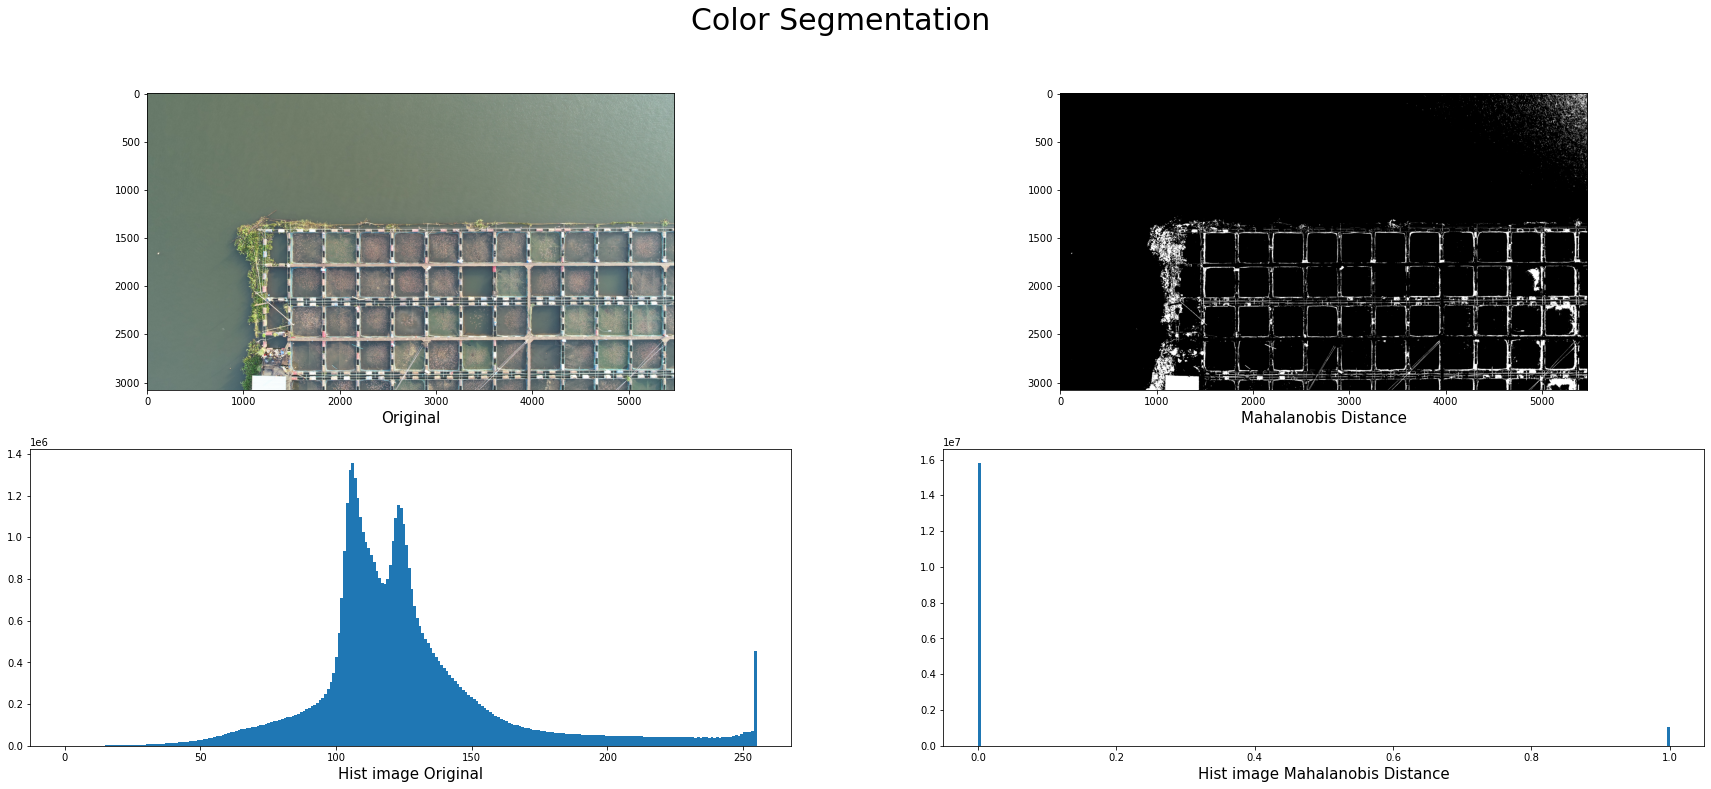

In [38]:
ImageSubplot(img_in = [IMG_Origi,IMG_OUT_mahalanobisDistance],img_name =["Original","Mahalanobis Distance"],Title = "Color Segmentation")

Intersection over Union 0.28


False = 0      True = 1  Precision
False = 0  1.478264e+07  1.001264e+06   0.936564
True = 1   4.881420e+05  5.707660e+05   0.539014
Recall     9.680343e-01  3.630758e-01   0.911570

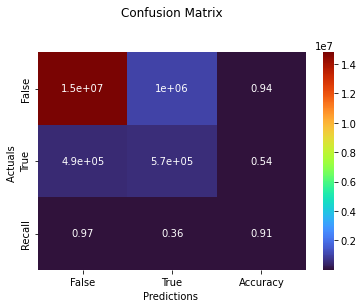

In [39]:
IoU_Conf_Plotconf(IMG_Grund_truth_binary, IMG_OUT_mahalanobisDistance)

## 4. การทดลอง K-mean Clustering
#### ทำการทดลองใช้อัลกอริทึม K-mean Clustering กับภาพนำเข้าต้นฉบับ (แนะนำใน Program-16) ดังนี้

### 4.1 นำภาพนำเข้าต้นฉบับโมเดลสี RGB เข้าอัลกอริทึม K-mean Clustering กำหนดค่า K ตามความเหมาะสม และเลือกกลุ่ม K ตามวัตถุประสงค์ที่ต้องการ แสดงภาพก่อนและหลังการประมวลผล พร้อมวัดผลโดยการหา IoU และ Confusion Matrix และแสดงหรือแนบโปรแกรม Python ที่ใช้


In [55]:
def kmeanSegmentation(input_img, k):
    y, x, z = input_img.shape
    ### -> reshape image into records
    input_rec = input_img.reshape(y*x, z)
    input_rec = input_rec.astype(np.float32)
    ### -> K-means Clustering
    criteria = (cv2.TERM_CRITERIA_MAX_ITER+cv2.TERM_CRITERIA_EPS, 100, 0.2)
    _, label_rec, (centers) = cv2.kmeans(input_rec, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    ### -> reshape records into image
    label_rec = label_rec.flatten()
    label_img = label_rec.reshape((y, x))

    return label_img, centers.astype(np.uint8)

def selectGroup(label_img, centers):
    ### -> Focus Red
    select_group = np.argwhere(centers[:,0] > np.mean(centers[:,0])).flatten()
    ### -> Select
    output_img = np.isin(label_img, select_group)
    output_img = output_img.astype(np.uint8)
    return output_img

def Kmean_func(input_img, k):
    label_img, centers = kmeanSegmentation(input_img, k)
    
    ImageSubplot(img_in = [input_img,label_img],img_name =["Original","label image"],Title = "K-mean")
    
    IMG_OUT = selectGroup(label_img, centers)
    
    return IMG_OUT
    

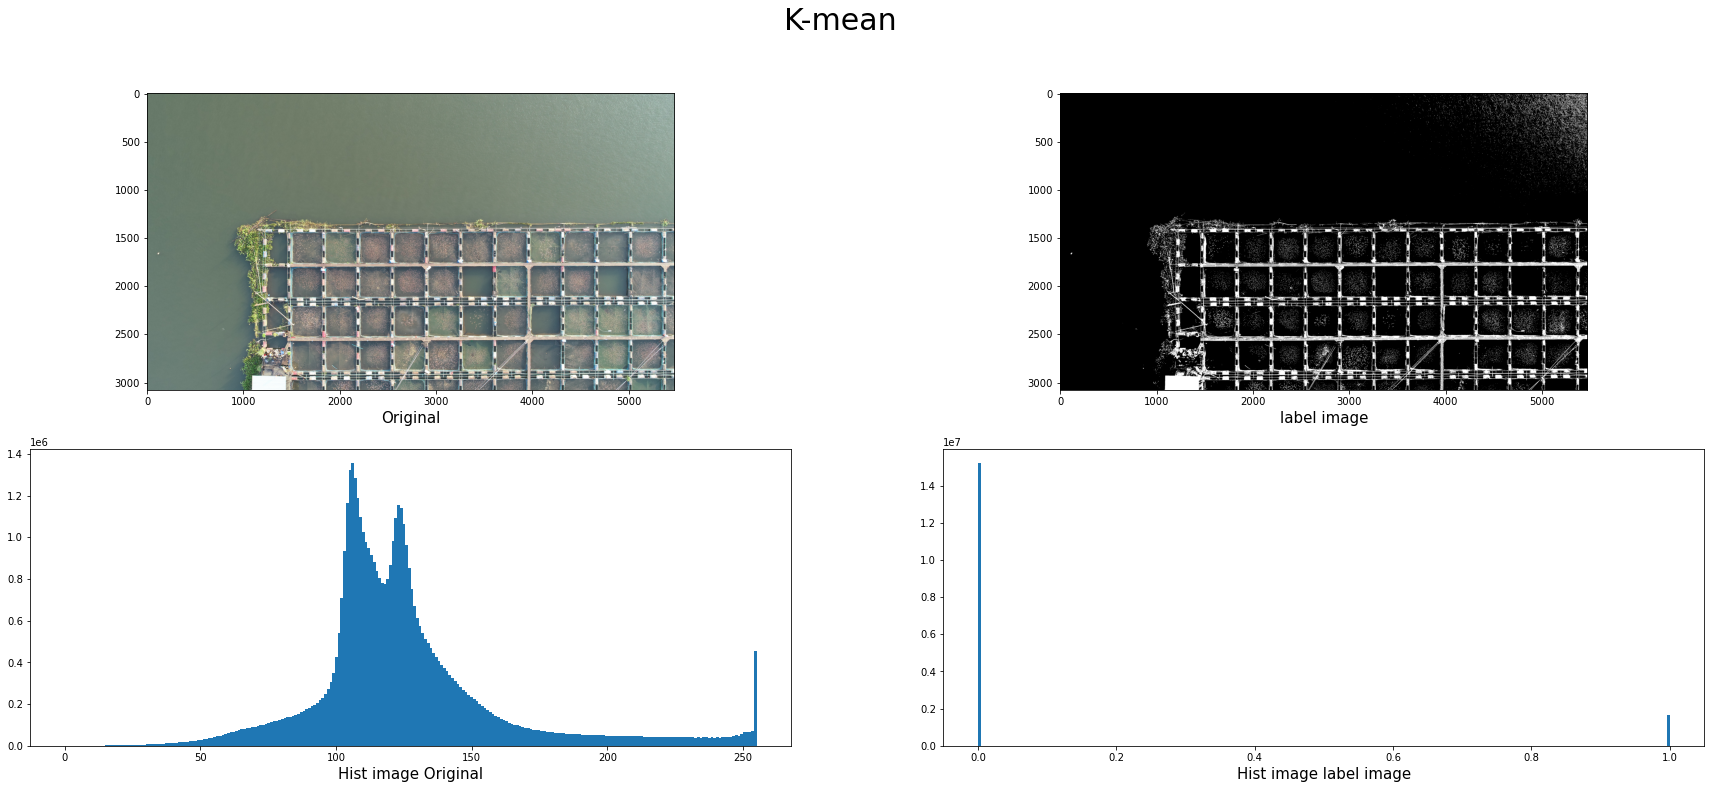

In [59]:
K_mean_segment = Kmean_func(IMG_Origi, k = 2)

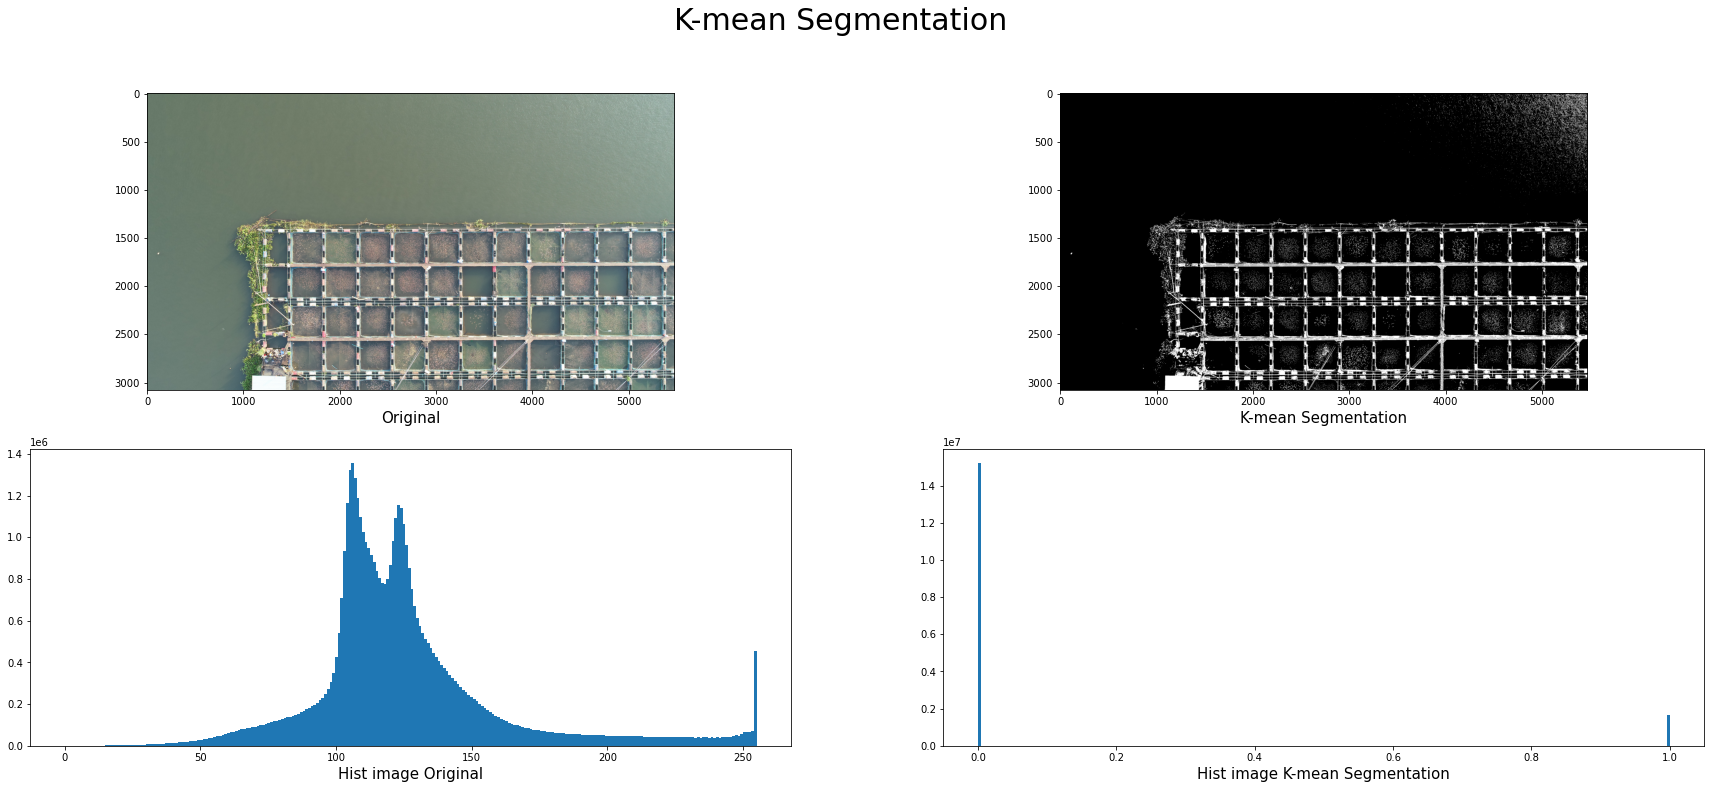

In [60]:
ImageSubplot(img_in = [IMG_Origi,K_mean_segment],img_name =["Original","K-mean Segmentation"],Title = "K-mean Segmentation")

Intersection over Union 0.64


False = 0      True = 1  Precision
False = 0  1.488550e+07  3.102780e+05   0.979581
True = 1   3.852910e+05  1.261752e+06   0.766071
Recall     9.747694e-01  8.026259e-01   0.958702

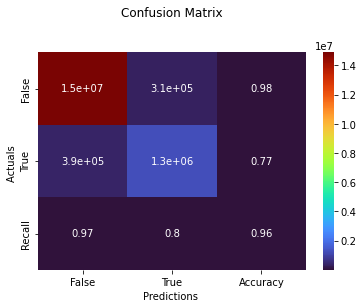

In [43]:
IoU_Conf_Plotconf(IMG_Grund_truth_binary, K_mean_segment)

In [54]:
K_mean_segment_save = np.where(K_mean_segment == 0,0,255)
cv2.imwrite("Segmentation_kmean.JPG",K_mean_segment_save)

True

### 4.2 นำภาพนำเข้าต้นฉบับโมเดลสี HSV เข้าอัลกอริทึม K-mean Clustering กำหนดค่า K ตามความเหมาะสม และเลือกกลุ่ม K ตามวัตถุประสงค์ที่ต้องการ แสดงภาพก่อนและหลังการประมวลผล พร้อมวัดผลโดยการหา IoU และ Confusion Matrix และแสดงหรือแนบโปรแกรม Python ที่ใช้


In [44]:
IMG_Origi_HSV = cv2.cvtColor(IMG_Origi, cv2.COLOR_RGB2HSV)

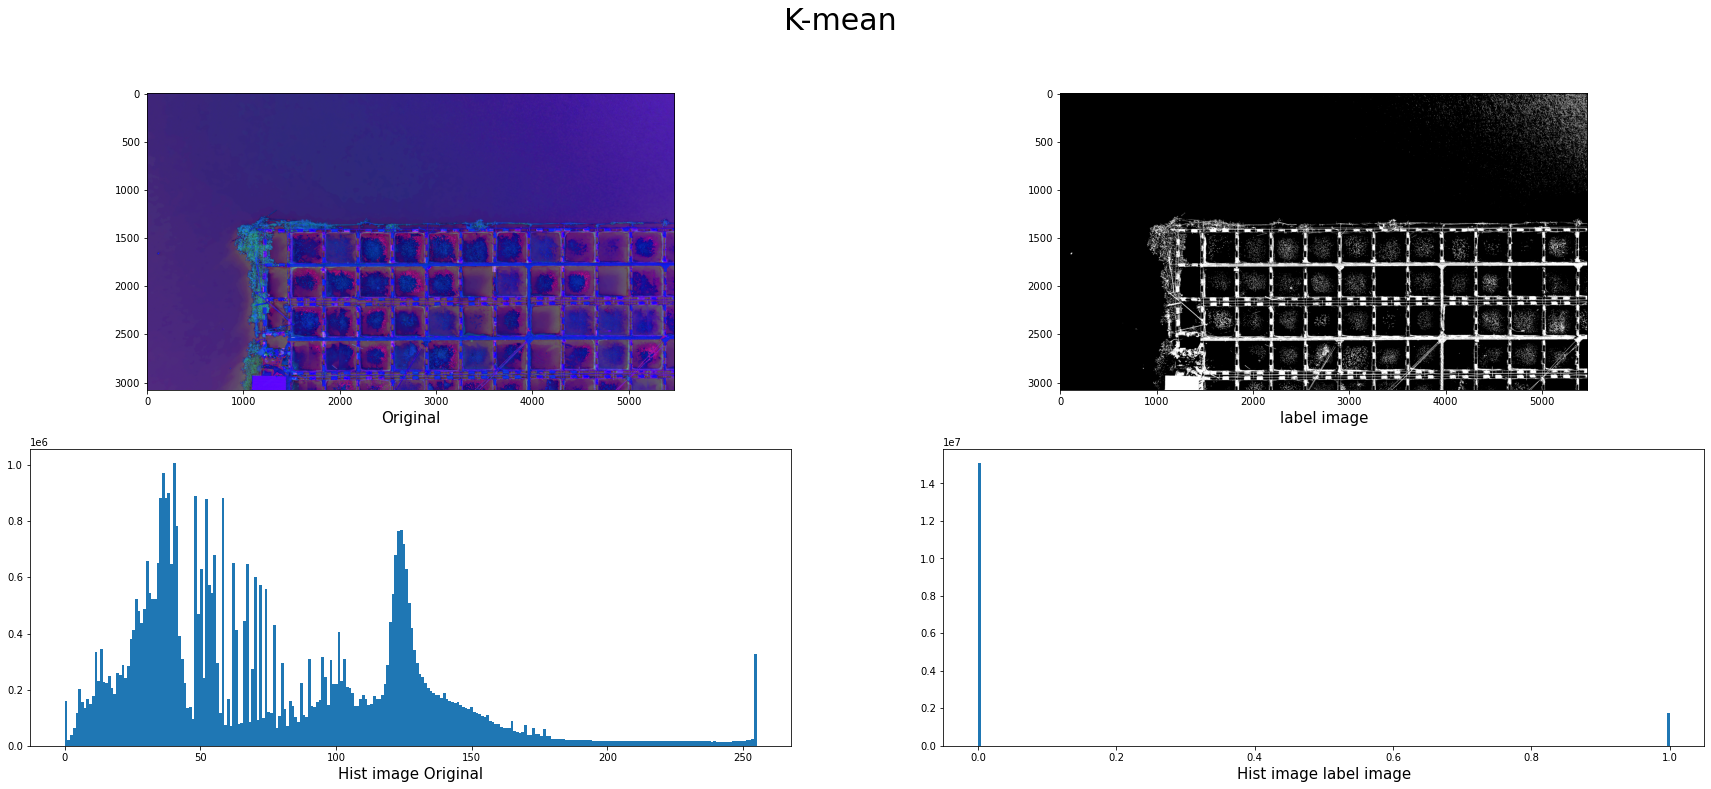

In [45]:
K_mean_segment_HSV = Kmean_func(IMG_Origi_HSV, k = 2)

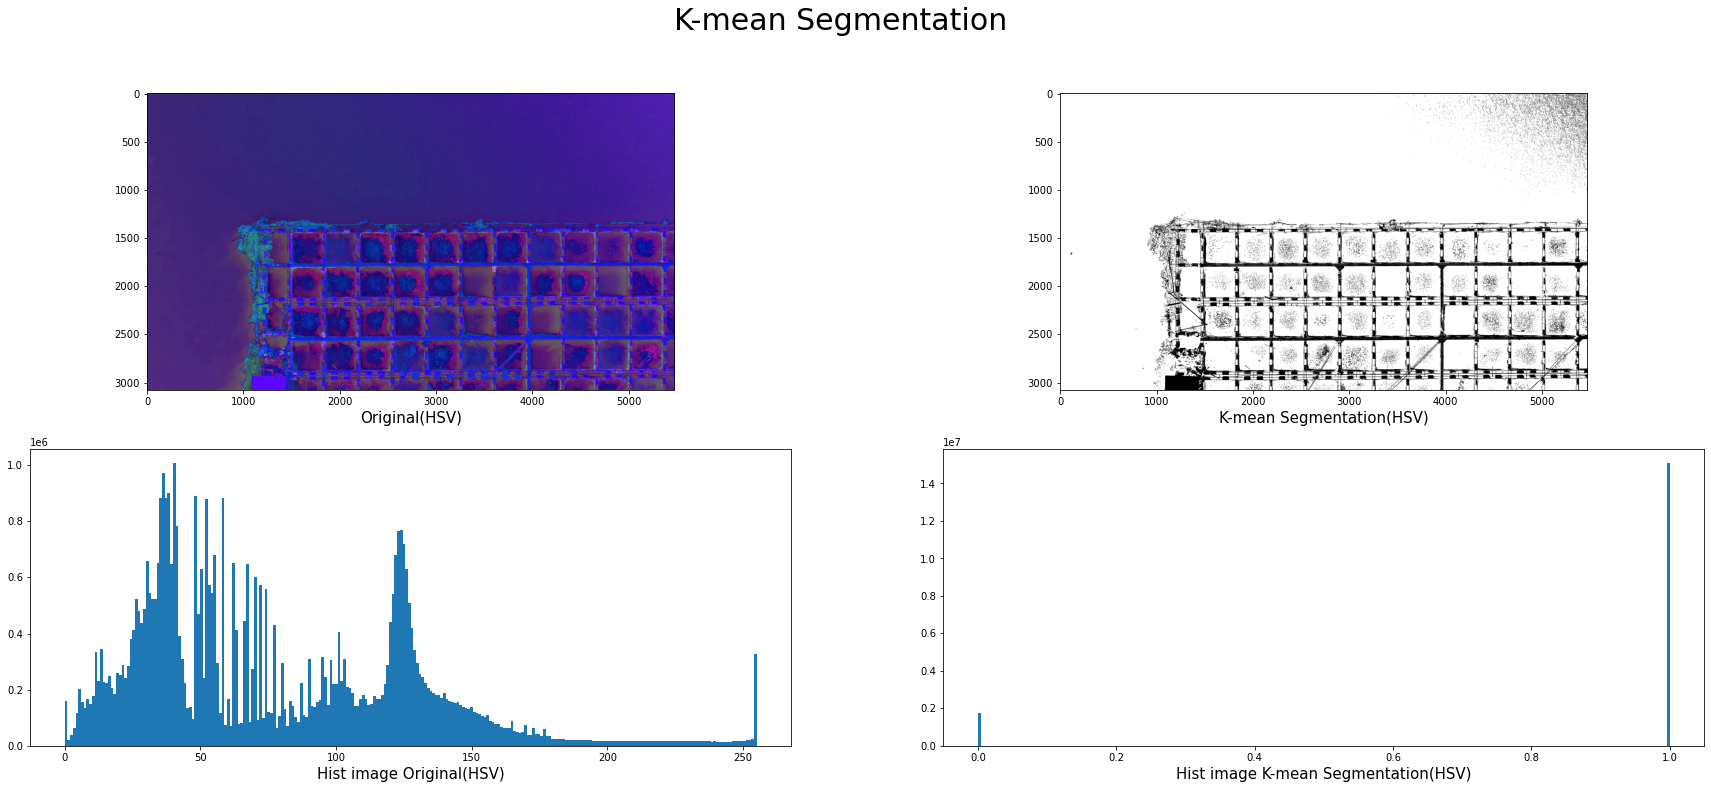

In [46]:
ImageSubplot(img_in = [IMG_Origi_HSV,K_mean_segment_HSV],img_name =["Original(HSV)","K-mean Segmentation(HSV)"],Title = "K-mean Segmentation")

In [48]:
K_mean_segment_HSV = np.where(K_mean_segment_HSV == 0,1,0)

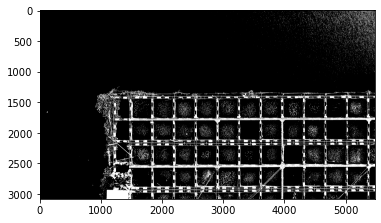

In [51]:
plt.imshow(K_mean_segment_HSV,cmap="gray")

Intersection over Union 0.64


False = 0      True = 1  Precision
False = 0  1.480293e+07  2.644760e+05   0.982447
True = 1   4.678520e+05  1.307554e+06   0.736482
Recall     9.693629e-01  8.317615e-01   0.956520

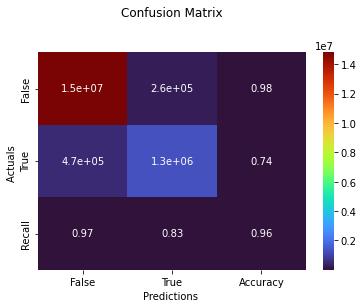

In [49]:
IoU_Conf_Plotconf(IMG_Grund_truth_binary, K_mean_segment_HSV)

## 5. สรุปผลการทดลอง Segmentation
#### สร้างตารางเปรียบเทียบผลลัพท์ค่า Accuracy และ IoU จากทุกวิธีที่ทำ คือ 2.1, 2.2, 3.1, 3.2, 3.3, 4.1, 4.2 โดย วิเคราะห์ผลการทดลองที่ได้จากการทดลอง Segmentation ของแต่ละวิธีว่ามีข้อได้เปรียบและข้อด้อยอย่างไร ตรงตามวัตถุประสงค์ในการทำ Segmentation ที่ต้องการหรือไม่

In [52]:
Compare = np.ones((7,2))
# 2.1
Compare[0][0] = findIoU(IMG_Grund_truth_binary, output_img_Optimum_Threshold)
Compare[0][1] = findAccuracy(IMG_Grund_truth_binary, output_img_Optimum_Threshold)
# 2.2
Compare[1][0] = findIoU(IMG_Grund_truth_binary, output_img_Otsu_Thresholding)
Compare[1][1] = findAccuracy(IMG_Grund_truth_binary, output_img_Otsu_Thresholding)
# 3.1
Compare[2][0] = findIoU(IMG_Grund_truth_binary, output_img_inRange)
Compare[2][1] = findAccuracy(IMG_Grund_truth_binary, output_img_inRange)
# 3.2
Compare[3][0] = findIoU(IMG_Grund_truth_binary, IMG_OUT_EuclideanDistance)
Compare[3][1] = findAccuracy(IMG_Grund_truth_binary, IMG_OUT_EuclideanDistance)
# 3.3
Compare[4][0] = findIoU(IMG_Grund_truth_binary, IMG_OUT_mahalanobisDistance)
Compare[4][1] = findAccuracy(IMG_Grund_truth_binary, IMG_OUT_mahalanobisDistance)
# 4.1
Compare[5][0] = findIoU(IMG_Grund_truth_binary, K_mean_segment)
Compare[5][1] = findAccuracy(IMG_Grund_truth_binary, K_mean_segment)
# 4.2
Compare[6][0] = findIoU(IMG_Grund_truth_binary, K_mean_segment_HSV)
Compare[6][1] = findAccuracy(IMG_Grund_truth_binary, K_mean_segment_HSV)

In [53]:
df = pd.DataFrame(Compare, columns = ['Intersection over Union','Accuracy'], index = ['2.1', '2.2', '3.1', '3.2', '3.3', '4.1', '4.2' ])
display(df)

Intersection over Union  Accuracy
2.1                 0.557104  0.955644
2.2                 0.634681  0.955235
3.1                 0.304507  0.934510
3.2                 0.000000  0.877321
3.3                 0.277048  0.911570
4.1                 0.644632  0.958702
4.2                 0.640995  0.956520

#### เมื่อพิจารณาภาพที่ได้จากการ segmentation ค่า Accuracy ได้ค่าที่น่าพอใจ แต่มีปัญหาในข้อ 4.2 ที่ใช้โมเดลสี HSV ซึ่งทำให้ภาพสุดท้ายที่ออกมาเป็นภาพ Inverse ของภาพ Grund truth และในวิธีข้อ 3.2 และ 3.3 ได้ปรับค่าภาพที่ออกมาให้เป็นค่า inverse ของวิธีที่แนะนำใน Program-16 